## Intro

I'm Amit Hofree, I.D 208117341, and I'm a CS student in the Open University of Israel.

For this project, I knew I wanted to deal with textual data, as last semester I took a course in computer vision, and I've felt that textual analysis (including NLP) is an interesting and prominent area in data science that I would like to explore more.

When trying to find an interesting problem that involves textual data, I came across the problem of programming language classification. This problem especially attracted me, as a part of my job includes processing code written in different programming languages, and the idea that I could leverage data science tools to make this processing more informative and customer-friendly excited me.

### The problem

In this technological age we live in, source code is becoming more and more ubiquitous.

More and more software companies and projects are started every day, and source code is becoming more advanced, feature-filled and multi-purpose than ever before.

Source code is often classified by its "language", the collection of syntax and rules that the script must obey in order to be understood by the compiler and translated into a well defined executable.

The aim of this project is to create a system for classifying source code snippets and files using only the source code content, without file extension or context, using machine learning tools.

A possible use for this system could be an advanced DLP (Data Loss Prevention) system, that monitors source code traffic in a network. Alternatively, it could be used in an IM client (Slack / Discord) to add correct syntax highlighting to a shared code snippet. More possibilities can be considered, as long as the system can detect the code in an efficient and satisfactory manner.

For this project, we will try to tell apart the 10 most common programming langauges, according to [Github](https://octoverse.github.com/) - 

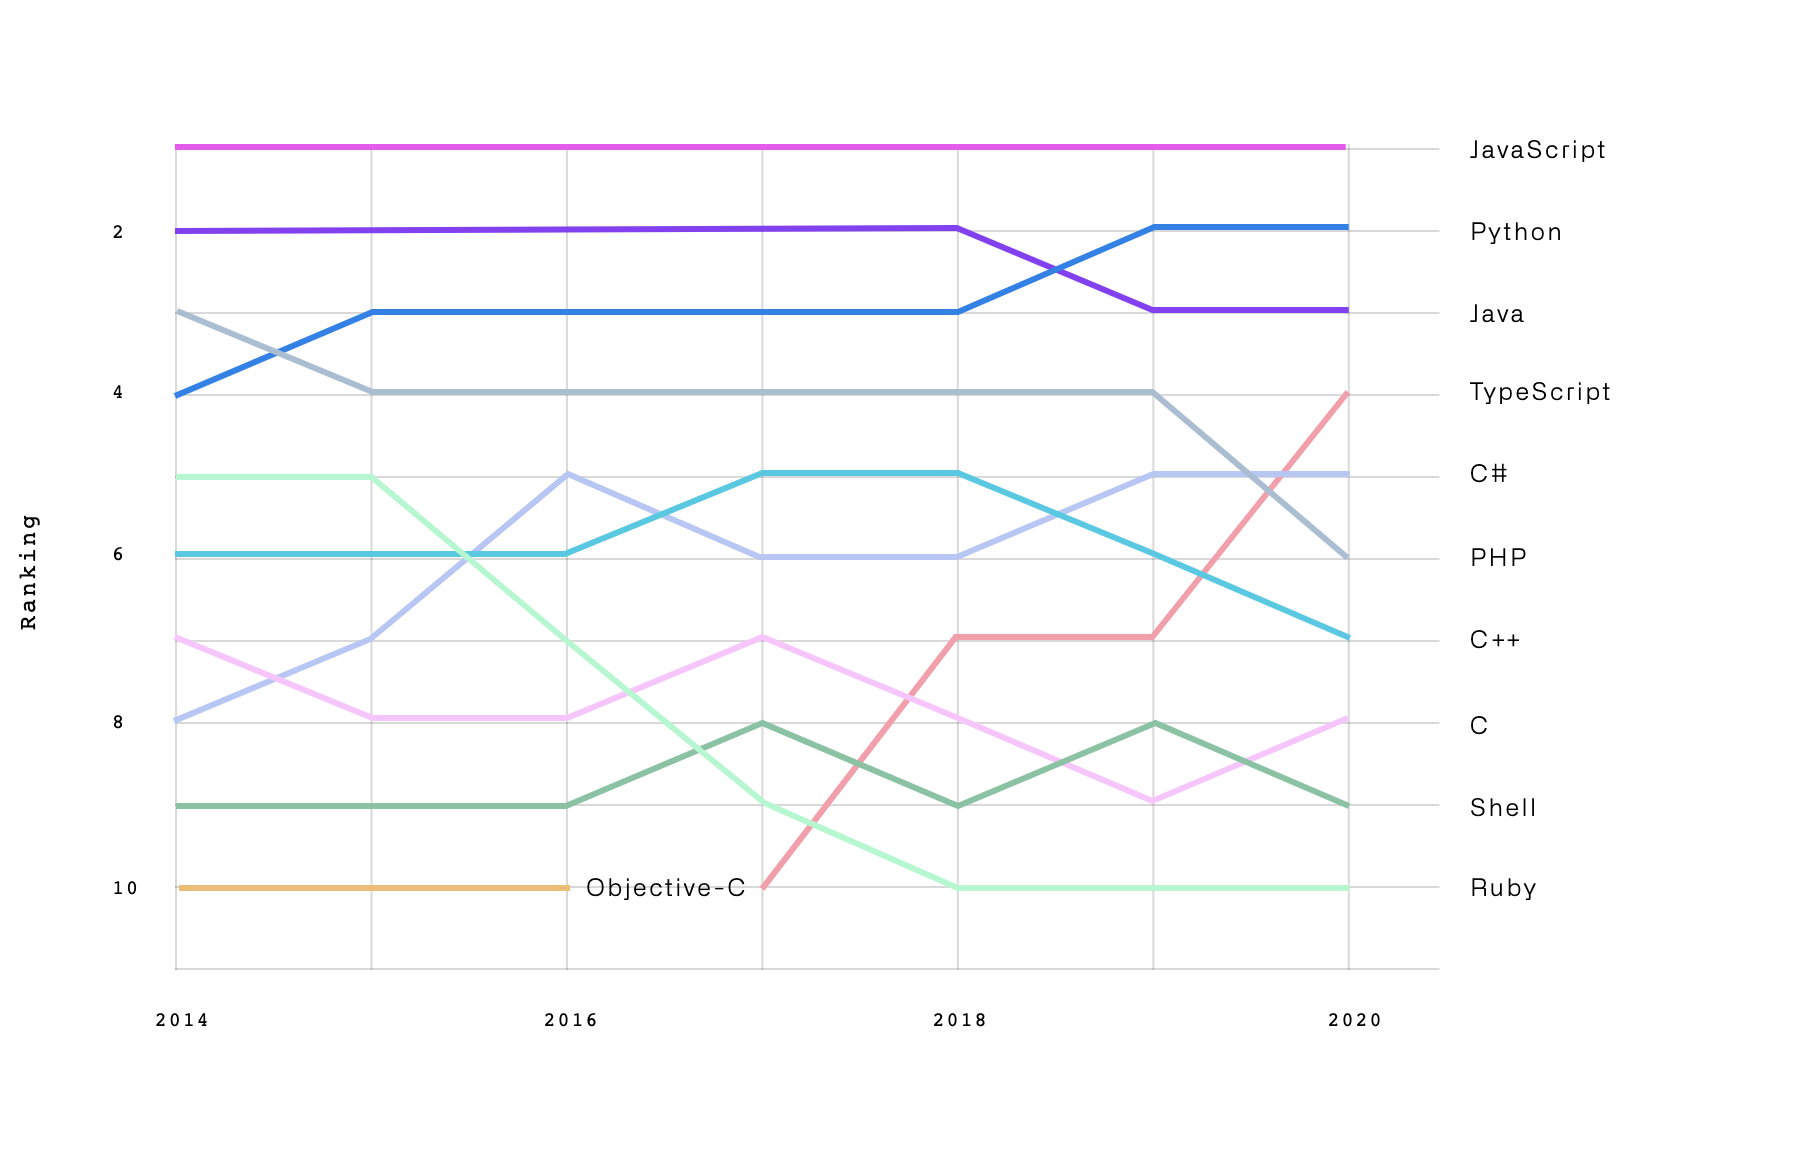

For this classifier to be useful, we would like it to be functional and accurate for chunks of code of arbitrarily length, and with acceptable loss of accuracy for smaller chunks.

In addition, a dataset of different programming languages snippets was not supplied, and thus a part of this project will be focused on acquiring plenty of quality samples that could be used for classification.

### Domain knowledge dive

Programming languages may be divided into different categories in a number of ways.
A common way to divide programming languages is according to the programming paradigm(s) supported by the language.
A number of common programming paradigms are - 
* Procedural
* Functional
* Reactive
* Object Oriented

Solving a computing problem in different programming paradigms often yields code that is very different. For examples - 
```scheme
(define (sieve n)
  (define (aux u v)
    (let ((p (car v)))
      (if (> (* p p) n)
        (let rev-append ((u u) (v v))
          (if (null? u) v (rev-append (cdr u) (cons (car u) v))))
        (aux (cons p u)
          (let wheel ((u '()) (v (cdr v)) (a (* p p)))
            (cond ((null? v) (reverse u))
                  ((= (car v) a) (wheel u (cdr v) (+ a p)))
                  ((> (car v) a) (wheel u v (+ a p)))
                  (else (wheel (cons (car v) u) (cdr v) a))))))))
  (aux '(2)
    (let range ((v '()) (k (if (odd? n) n (- n 1))))
      (if (< k 3) v (range (cons k v) (- k 2))))))
```
 in Scheme, versus -
```python
def primes_upto(limit):
    is_prime = [False] * 2 + [True] * (limit - 1) 
    for n in range(int(limit**0.5 + 1.5)): # stop at ``sqrt(limit)``
        if is_prime[n]:
            for i in range(n*n, limit+1, n):
                is_prime[i] = False
    return [i for i, prime in enumerate(is_prime) if prime]
```
in Python.

The Python sample is using a procedural paradigm, while the Scheme examples is using functional paradigm. Compare that to this Ruby version, which also uses a procedural paradigm - 
```ruby
def eratosthenes(n)
  nums = [nil, nil, *2..n]
  (2..Math.sqrt(n)).each do |i|
    (i**2..n).step(i){|m| nums[m] = nil}  if nums[i]
  end
  nums.compact
end
```

The code samples look much more similar in structure, and in truth execute very similarily.

However, this distinction is often lost because a lot of the programming languages today support multiple programming paradigms, and as such it will be difficult for us differentiate programming languages based on this metric.

Another possible distinction is the handling of types in the programming language.
Types in programming languages refer to the different types of data handled using the programming language's constructs. Some programming languages support having different types of variables (for example, C), while others do not differentiate between different types (for example x86 Assembly).
Some types, such as strings (representing an ordered collection of characters) are very common, while others are very specific to the language.
In addition, programming languages are often classified as having a static or dynamic type system, which has to do with whether the type of a variable has to be detectable in a determinstic way before executing the programming, or whether it is only assigned a type when needed (often when first using the variable in the code).

To add another challenge, some programming languages are based on, or have syntax inspired by other programming languages.
For example, the 10 most commonly used programming languages in 2020 according to GitHub are -
1. JavaScript
2. Python
3. Java
4. TypeScript
5. C#
6. PHP
7. C++
8. C
9. Shell
10. Ruby

In this list alone, TypeScript is a strict superset of JavaScript, meaning all the features supported in JavaScript are also supported in TypeScript, C++ is a superset of C (although less strict, some specific expressions in C are illegal in C++), and Java and C# both have syntax that is strongly inspired by C.

Therefore, in order to classify between the different programming languages, it is likely that we need to use very specific identifying features of each programming language.

### Initial data gathering

As an easy method to gather data for exploration and classification, I opted to use "Rosetta Code".

According to the Rosetta Code website - 
> Rosetta Code is a programming chrestomathy site. The idea is to present  solutions to the same task in as many different languages as possible, to demonstrate how languages are similar and different, and to aid a person with a grounding in one approach to a problem in learning another.

Rosetta Code catalogs different well-known programming problems, and presents a solution for each problem in many different programming languages. These solutions are contributed by the Rosetta Code community, and more solutions and problems are added over time.

Rosetta Code is built on MediaWiki, the same platform running Wikipedia and other wiki sites, and unfortunately does not expose an well-defined API for data scraping.

To deal with this, I'm using a file based copy of the site, available via this GitHub repository - https://github.com/acmeism/RosettaCodeData.

The data in this copy is not automatically updated (and therefore could be a bit outdated), but working with locally stored samples proved to be very fast and comfortable.

## EDA

In [8]:
import os
import random
import string
import re

import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize 

In [9]:
LANG_PATH = "RosettaCodeData/Lang"
TOP_LANGUAGES = ["JavaScript", "Python", "Java", "TypeScript", "C-Sharp", "PHP", "C++", "C", "UNIX-Shell", "Ruby"]

SAMPLE_IDX = 0
LABEL_IDX = 1

SEED = 4242
random.seed(SEED)

Let's check how the data is stored in the RosettaCodeData repository.

In [3]:
!ls RosettaCodeData/Lang

0815                                  Lout
360-Assembly                          Lua
4D                                    Lucid
4DOS-Batch                            Luck
6502-Assembly                         Lush
6800-Assembly                         Lygon
68000-Assembly                        M4
8-1-2                                 M680x0
80386-Assembly                        MAPPER
8051-Assembly                         MATLAB
8080-Assembly                         MAXScript
8086-Assembly                         MBS
8th                                   ME10-macro
A+                                    MEL
ABAP                                  MGS
ACL2                                  MINIL
ALGOL                                 MIPS-Assembly
ALGOL-60                              MIRC-Scripting-Language
ALGOL-68                              ML-I
ALGOL-M                               MLite
ALGOL-W                               MMIX
AMPL                                  MOO
ANT         

In [4]:
!ls RosettaCodeData/Lang/Python

00DESCRIPTION
100-doors
24-game
24-game-Solve
9-billion-names-of-God-the-integer
99-Bottles-of-Beer
A+B
ABC-Problem
AKS-test-for-primes
Abstract-type
Abundant,-deficient-and-perfect-number-classifications
Accumulator-factory
Ackermann-function
Active-Directory-Connect
Active-Directory-Search-for-a-user
Active-object
Add-a-variable-to-a-class-instance-at-runtime
Address-of-a-variable
Align-columns
Aliquot-sequence-classifications
Almost-prime
Amb
Amicable-pairs
Anagrams
Anagrams-Deranged-anagrams
Animate-a-pendulum
Animation
Anonymous-recursion
Append-a-record-to-the-end-of-a-text-file
Apply-a-callback-to-an-array
Arbitrary-precision-integers--included-
Arithmetic-Complex
Arithmetic-Integer
Arithmetic-Rational
Arithmetic-evaluation
Arithmetic-geometric-mean
Arithmetic-geometric-mean-Calculate-Pi
Array-concatenation
Arrays
Assertions
Associative-array-Creation
Associative-array-Iteration
Atomic-updates
Average-loop-length
Averages-Arithmetic-mean
Averages-Mean-angle
Averages-Mean-time-of

In [5]:
!ls RosettaCodeData/Lang/Python/AKS-test-for-primes

aks-test-for-primes-1.py aks-test-for-primes-3.py
aks-test-for-primes-2.py aks-test-for-primes-4.py


In [7]:
!cat RosettaCodeData/Lang/Python/AKS-test-for-primes/aks-test-for-primes-1.py

def expand_x_1(n):
# This version uses a generator and thus less computations
    c =1
    for i in range(n//2+1):
        c = c*(n-i)//(i+1)
        yield c

def aks(p):
    if p==2:
        return True

    for i in expand_x_1(p):
        if i % p:
# we stop without computing all possible solutions
            return False
    return True


The directory format is Language/Problem/Sample.
The stored sample code is pure code without any headers or licensing data to strip.

Let's build a dataset out of the relevant samples, so we can explore it in an orderly manner.

In [30]:
def build_lang_dataset(lang):
    source_files = []
    tasks_path = os.path.join(LANG_PATH, lang)
    task_names = [name for name in os.listdir(tasks_path) if os.path.isdir(os.path.join(tasks_path, name))]
    for task_name in task_names:
        task_path = os.path.join(tasks_path, task_name)
        source_file_names = os.listdir(task_path)
        for source_file_name in source_file_names:
            source_file_path = os.path.join(task_path, source_file_name)
            with open(source_file_path, "r") as source_file_obj:
                source_files.append((source_file_obj.read(), lang))
    return source_files

def build_dataset():
    source_files = []
    for lang in TOP_LANGUAGES:
        source_files += build_lang_dataset(lang)
    return source_files

In [31]:
dataset = build_dataset()

In [32]:
random.shuffle(dataset)

The dataset we built is a list of 2 element tuples, where the first element is a sample from RosettaCode, and the second element is the name of the programming language used in that sample.

Let's check how the samples are distributed according to programming languages.

In [26]:
from collections import Counter
counter = Counter([item[LABEL_IDX] for item in dataset])
counter_dict = dict(counter)
languages = list(counter_dict.keys())
counts = [counter_dict[lang] for lang in x]

<AxesSubplot:>

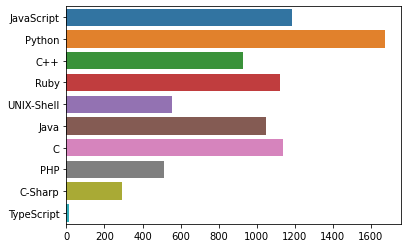

In [27]:
sns.barplot(x=counts, y=languages)

We can see already that our dataset is heavily skewed - we have very little TypeScript samples, and a lot of Python samples.

Let's examine the average sample line count for every lanague.

In [40]:
lang_line_counts = {lang: [] for lang in languages}
for item in dataset:
    lang = item[LABEL_IDX]
    sample = item[SAMPLE_IDX]
    sample_line_count = len(sample.split("\n"))
    lang_line_counts[lang].append(sample_line_count)

lang_line_avg = {}
for lang in lang_line_counts.keys():
    lang_line_count = lang_line_counts[lang]
    lang_line_avg[lang] = sum(lang_line_count) / len(lang_line_count)
    
languages = list(lang_line_avg.keys())
line_counts = [lang_line_avg[lang] for lang in x]

<AxesSubplot:>

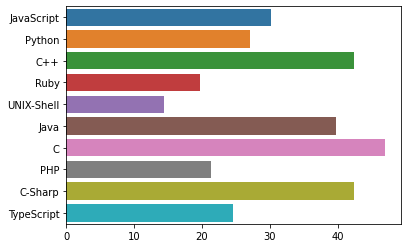

In [39]:
sns.barplot(x=line_counts, y=languages)

We can see there is a noticeable difference in line count between different languages. This might be a characteristic of the programming language we can leverage later on, but if we expect our classifier to work for samples of random length, we might not want to use it.

Finally, let's check the average line length for each sample.

In [35]:
lang_line_lengths = {lang: [] for lang in languages}
for item in dataset:
    lang = item[LABEL_IDX]
    sample = item[SAMPLE_IDX]
    sample_lines = sample.split("\n")
    sample_line_lengths = [len(line) for line in sample_lines]
    avg_sample_line_lengths = sum(sample_line_lengths) / len(sample_line_lengths)
    lang_line_lengths[lang].append(avg_sample_line_lengths)

lang_line_avg = {}
for lang in lang_line_lengths.keys():
    lang_line_length = lang_line_lengths[lang]
    lang_line_avg[lang] = sum(lang_line_length) / len(lang_line_length)
    
languages = list(lang_line_avg.keys())
line_lengths = [lang_line_avg[lang] for lang in x]

<AxesSubplot:>

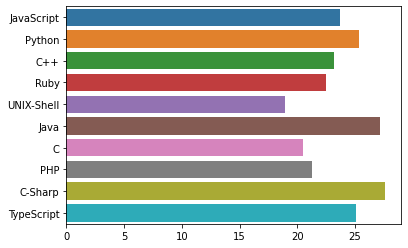

In [37]:
sns.barplot(x=line_lengths, y=languages)

As we can see, the line lengths between languages are pretty similar. This makes sense as a lot of IDEs and linters (Programs that assist programmers to write code) enforce a line length limit to improve the readability of the code.

### Feature extraction
Naturally, being based on text, the samples retrieved here don't have any pre-defined features.

We will attempt to use several ideas and techniques to extract features from the dataset that will be used for classification.

#### Special characters
The usage of symbolic characters is very common in most programming languages. For example, the C programming language uses curly braces ('{', '}') to define function and control flow scopes, and Java uses semicolons (;) to separate statements in the code.

We will try to see if examining the usage of these special characters can give us good separation between the programming languages used in the samples.

In [11]:
SPECIAL_CHARACTERS = string.punctuation
samples = [item[0] for item in dataset]
labels = [item[1] for item in dataset]

Let's try and examine if different programming languages can be separated by their most common special character

We use `CountVectorizer` to determine the number of apperances for each special character in each sample, and then we use `numpy.argmax` to get the index of the most common special character.

In [12]:
dataset_df = pd.DataFrame(dataset, columns=["Sample", "Label"])

In [14]:
cv = CountVectorizer(vocabulary=SPECIAL_CHARACTERS, analyzer='char')
special_char_vector = cv.fit_transform(dataset_df["Sample"])
most_common_special = [vec.A[0].argmax() for vec in special_char_vector]
most_common_special_symbol = [cv.vocabulary[idx] for idx in most_common_special]
dataset_df["Most Common Special Character"] = most_common_special_symbol

In [15]:
dataset_df

,Sample,Label,Most Common Special Character
0,function unique(ary) {\n // concat() with n...,JavaScript,""""
1,>>> extra = 'little'\n>>> f'Mary had a {extra}...,Python,>
2,"#include <iostream>\nint main(int argc, char* ...",C++,/
3,# Or without the temp variable\n# (it's up to ...,Python,","
4,#!/usr/bin/ruby -w\nrequire 'rubygems'\nrequir...,Ruby,'
...,...,...,...
8476,/* 5432.c */\n\n#include <openssl/bn.h>\t\t/* ...,C,(
8477,#include <stdio.h>\n#include <stdlib.h>\n\n#in...,C,","
8478,(() => {\n 'use strict';\n\n // factoria...,JavaScript,-
8479,"from numpy import array, bool_, multiply, nonz...",Python,","


We'll now use pandas to get the most frequent character per language

In [16]:
dataset_df.groupby("Label")["Most Common Special Character"] \
          .agg(pd.Series.mode)

Label
C             ;
C++           :
C-Sharp       (
Java          (
JavaScript    (
PHP           $
Python        (
Ruby          .
TypeScript    (
UNIX-Shell    "
Name: Most Common Special Character, dtype: object

This could be useful, as we can see some languages have different most common special character.

However, we could be missing on an important detail here. It is possible that the most common special character for a language is only marginally more common, which would make it a bad candidate for separation.

Let's try plotting the percentage of samples that has a certain special characters as it's most common special character, divided by language.

To make the plot as clean as possible, only the top 5 most common special characters will be displayed.

In [17]:
percentage_df = dataset_df \
               .groupby(["Label", "Most Common Special Character"]) \
               .size() \
               .reset_index(name="Count")

In [34]:
percentage_df['Percentage'] = percentage_df.groupby("Label")['Count'] \
                                  .transform(lambda x: 100*x/sum(x)) \
                                  .astype('float')

In [35]:
sorted_df = percentage_df.sort_values(["Label", "Percentage"], \
                                      axis=0, ascending=False)

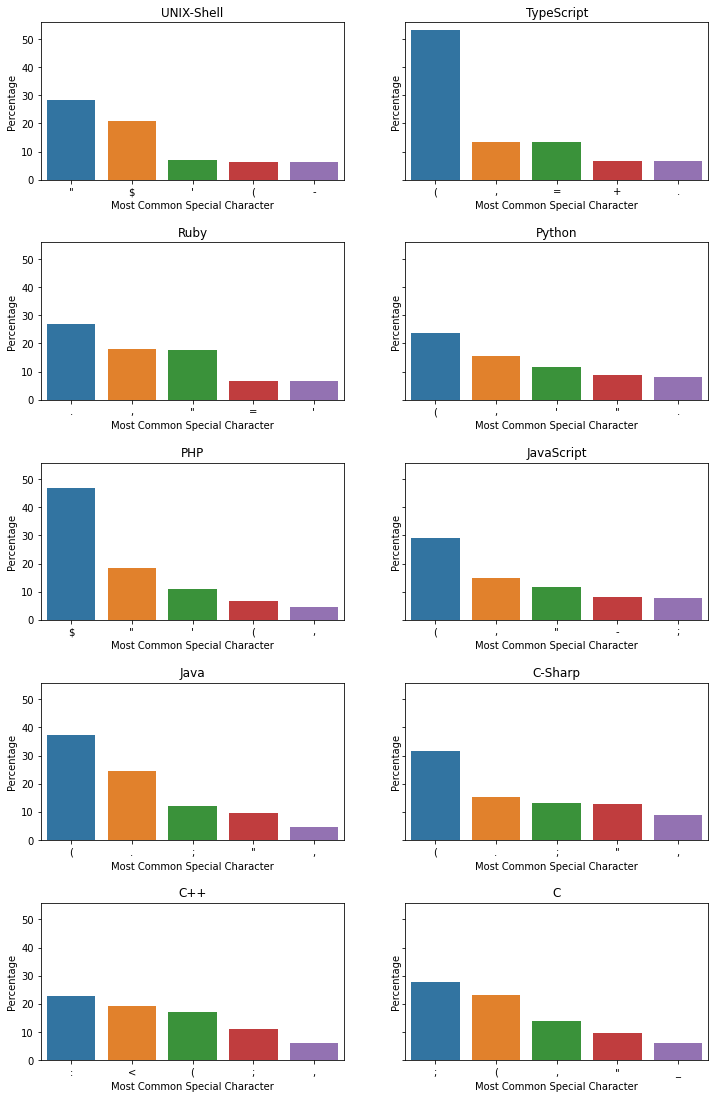

In [66]:
f, axes = plt.subplots(5, 2, figsize=(10, 15), sharey='all')
f.tight_layout()

i = 0
for lang in sorted_df["Label"].unique():
    ax = axes[i//2][i%2]
    ax.title.set_text(lang)
    lang_df = sorted_df[sorted_df["Label"] == lang].head(5)
    sns.barplot(x="Most Common Special Character", y="Percentage", \
                data=lang_df, ax=ax)
    plt.subplots_adjust(hspace = 0.4, wspace=0.2)
    i += 1

plt.show()

We can draw a number of conclusions from this - 
1. In most languages, the most common special character is the most common by a noticeable margin.
2. Certain special characters (such as ;) are much more prevalent in some programming languages, making them a good criteria for separation.
3. The set of the top 5 most common special characters is distinct for each language examined.

For point 3, note that for each of the top 5 most common special characters, we are referring to the top 1 most common special character per sample examined, rather then the top 5 for each sample, which would make a more sensible criteria for separation, but it gives a good idea of the power of this idea

#### Tokens
Another natural approach when working with textual data is tokenization.
In tokenization, we split the source code files and lines into separate "tokens" (in human-readable text, tokens can often be words), where each token is a certain unit of meaning with regards to the corpus of text data.

Many programming languages utilize the concept of reserved words - words that signify a certain structure or expression in the programming language, and can not be used in other contexts in the language.

For our task, we will try to extract these reserved words, and check if they are unique enough to help us distinguish between different languages.

In [33]:
import re
CUSTOM_TOKEN_RE=r"(?u)([a-zA-Z]\w+)(?: |.|,|;|\{|\}|\(|\)|\[|\]|<|>|\n|\t)"
SPECIAL_CHARACTERS = string.punctuation

In [34]:
samples = [item[0] for item in dataset]
labels = [item[1] for item in dataset]

To tokenize the source code, I've retrieved an example regular expression for tokenization of human-readable text from scikit-learn, and tweaked it to work with programming language token separators.


Let's take an example sample, and see the results of tokenization.

In [76]:
print(samples[0])

function unique(ary) {
    // concat() with no args is a way to clone an array
    var u = ary.concat().sort();
    for (var i = 1; i < u.length; ) {
        if (u[i-1] === u[i])
            u.splice(i,1);
        else
            i++;
    }
    return u;
}

var ary = [1, 2, 3, "a", "b", "c", 2, 3, 4, "b", "c", "d", "4"];
var uniq = unique(ary);
for (var i = 0; i < uniq.length; i++)
    print(uniq[i] + "\t" + typeof(uniq[i]));



In [77]:
re.findall(CUSTOM_TOKEN_RE, samples[0])

['function',
 'unique',
 'ary',
 'concat',
 'with',
 'no',
 'args',
 'is',
 'way',
 'to',
 'clone',
 'an',
 'array',
 'var',
 'ary',
 'concat',
 'sort',
 'for',
 'var',
 'length',
 'if',
 'splice',
 'else',
 'return',
 'var',
 'ary',
 'var',
 'uniq',
 'unique',
 'ary',
 'for',
 'var',
 'uniq',
 'length',
 'print',
 'uniq',
 'typeof',
 'uniq']

We can see all the relevant reserved words were extracted successfuly. However, together with these, some other irrelevant tokens were extracted, namely - 
* The contents of a comment, written by the programmer
* The names of the functions defined in the code.

For the last point, some built-in functions names may actually be indicative of the programming language used, but the function names chosen by the programmer, and any other programmer-generated symbol can be misleading for classification.

As a firt attempt, we will try to use a Bag of Words approach. We will sum up the number of appearances of these tokens using `CountVectorizer`, and normalize the resulting vectors in order to make them easier to visualize.
The resulting vector could be thought of as describing the entire sample using a fixed-size vector.

To deal with this, we will try to count and normalize using scikit-learn's `TfidfVectorizer` for each of the tokens to determine whether it is important with regards to the dataset.

In [182]:
vectorizer = CountVectorizer(token_pattern=CUSTOM_TOKEN_RE, lowercase=False, max_features=100)
vectors = vectorizer.fit_transform([item[SAMPLE_IDX] for item in dataset])
vectors = normalize(vectors)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count_df = pd.DataFrame(denselist, columns=feature_names)

In [98]:
count_df

,Int,Integer,Math,NULL,String,System,The,add,and,args,...,unsigned,using,value,var,vector,void,while,width,with,xs
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.152499,...,0.0,0.0,0.0,0.762493,0.0,0.000000,0.000000,0.0,0.152499,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.070186,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,0.000000,0.0,0.0,0.149487,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.074744,0.000000,0.0,0.000000,0.0
8477,0.000000,0.0,0.0,0.375326,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.083406,0.041703,0.0,0.000000,0.0
8478,0.745356,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
8479,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


We can see the different tokens received very different scores for the various samples, which can indicate they can be good features for our classifier.

Let's try plotting the TF-IDF token vector for each sample.

Because the token vector is high-dimensional data, we'll use PCA of dimensions 2 and 3 to make it visualizable in a normal plot.

In [99]:
pca = PCA(2)
pca_tfidf = pca.fit_transform(count_df)

<AxesSubplot:>

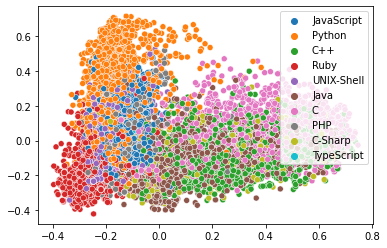

In [100]:
sns.scatterplot(x=[item[0] for item in pca_tfidf], y=[item[1] for item in pca_tfidf], hue=[item[1] for item in dataset])

And in 3D - 

In [101]:
def draw_3d_scatter(x, y, z, hue):
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    
    hue_classes = sorted(list(set(hue)))
    hue_transform = np.searchsorted(hue_classes, hue)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("tab10", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=10, c=hue_transform, marker='o', cmap=cmap, alpha=1)
    ax.set_xlabel('PCA 0')
    ax.set_ylabel('PCA 1')
    ax.set_zlabel('PCA 2')
    # legend
    plt.legend(sc.legend_elements()[0], hue_classes, bbox_to_anchor=(1.05, 1), loc=2)
    
    ax.elev = 10
    ax.azim = 30

    plt.show()

In [103]:
pca = PCA(3)
pca_3d_count = pca.fit_transform(count_df)

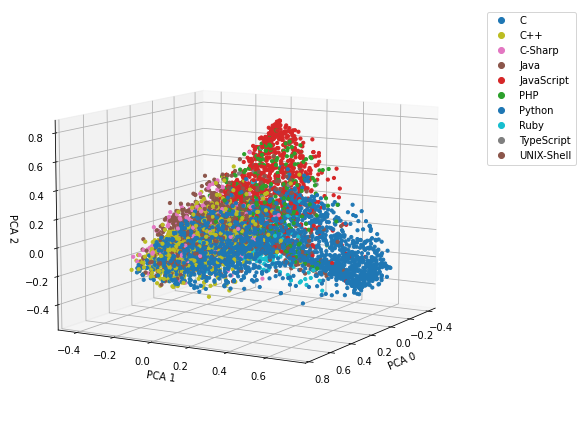

In [104]:
draw_3d_scatter([p[0] for p in pca_3d_count], [p[1] for p in pca_3d_count], [p[2] for p in pca_3d_count], [item[1] for item in dataset])

We can see we're starting to get some nice results, but the separation is still a bit unclear and muddy. 

Anoter way to improve this BoW approach is to consider the importance of each token with regards to the entire dataset, not just the examined sample. In this way, tokens that are used frequently in multiple programming languages can receive a lower score.

A very popular way to do this is using TF-IDF. In TF-IDF, we calculate the term frequency for each token (that is, its frequency with regards to the sample), multiplied by its inverse document frequency (that is, its frequency with regrads to the entire dataset).

To do this, we will use scikit-learn's `TfidfVectorizer`. Each sample will be translated into a vector, where each of the tokens will receive a score denoting it's importance.

In [190]:
vectorizer = TfidfVectorizer(token_pattern=CUSTOM_TOKEN_RE, lowercase=False, max_features=100)
vectors = vectorizer.fit_transform([item[SAMPLE_IDX] for item in dataset])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns=feature_names)

In [191]:
tfidf_df

,Int,Integer,Math,NULL,String,System,The,add,and,args,...,unsigned,using,value,var,vector,void,while,width,with,xs
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.161035,...,0.0,0.0,0.0,0.823932,0.0,0.000000,0.000000,0.0,0.169391,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062567,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8476,0.000000,0.0,0.0,0.229689,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.065552,0.000000,0.0,0.000000,0.0
8477,0.000000,0.0,0.0,0.514806,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.065299,0.033617,0.0,0.000000,0.0
8478,0.848916,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
8479,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


Once again, we'll use PCA to visualize the high-dimensional data.

In [192]:
pca = PCA(2)
pca_tfidf = pca.fit_transform(tfidf_df)

<AxesSubplot:>

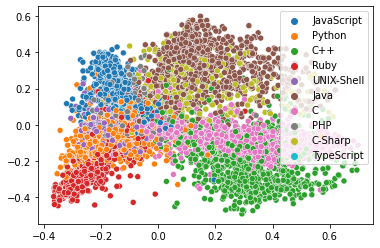

In [193]:
sns.scatterplot(x=[item[0] for item in pca_tfidf], y=[item[1] for item in pca_tfidf], hue=[item[1] for item in dataset])

And in 3D - 

In [178]:
pca = PCA(3)
pca_3d_tfidf = pca.fit_transform(tfidf_df)

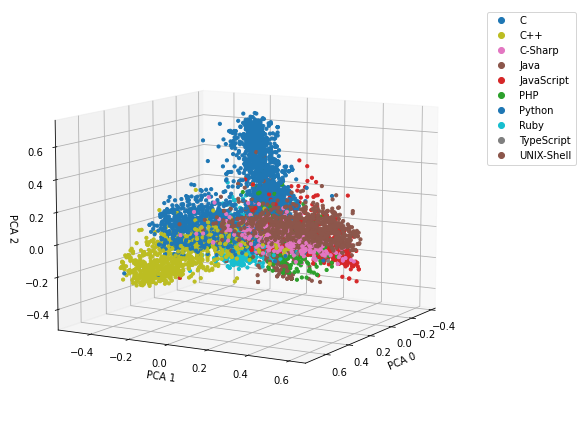

In [194]:
draw_3d_scatter([p[0] for p in pca_3d_tfidf], [p[1] for p in pca_3d_tfidf], [p[2] for p in pca_3d_tfidf], [item[1] for item in dataset])

It is now much more apparent that the samples belonging to each programming language converge in pretty clear clusters.

This is an improvement over the plots we have drawn using the normalized count vector representation, as the different dots (representing samples) are more easily discernible.

This is a very good sign that this feature could be used for classification.

Personally, I also find these plots very interesting, as they also show the similarities between this languages - 
* Points representing Javascript samples are very close to points representing Typescript samples
* The same can be said for Java and C#
* The same can be said for C and C++

This reaffirms my earlier statements about the similarities of these languages, and distills these similarities into a very visible and clear metric.

In order to optimize this feature, we need to try and choose the minimum number of vocabulary words (that is, tokens that are recognized) that will give us good separation.

In [197]:
def vectorize_and_pca(dataset, n, final_dimension=2):
    vectorizer = TfidfVectorizer(token_pattern=CUSTOM_TOKEN_RE, lowercase=False, max_features=n)
    vectors = vectorizer.fit_transform([item[SAMPLE_IDX] for item in dataset])
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    tfidf_df = pd.DataFrame(denselist, columns=feature_names)
    pca = PCA(final_dimension)
    return pca.fit_transform(tfidf_df)

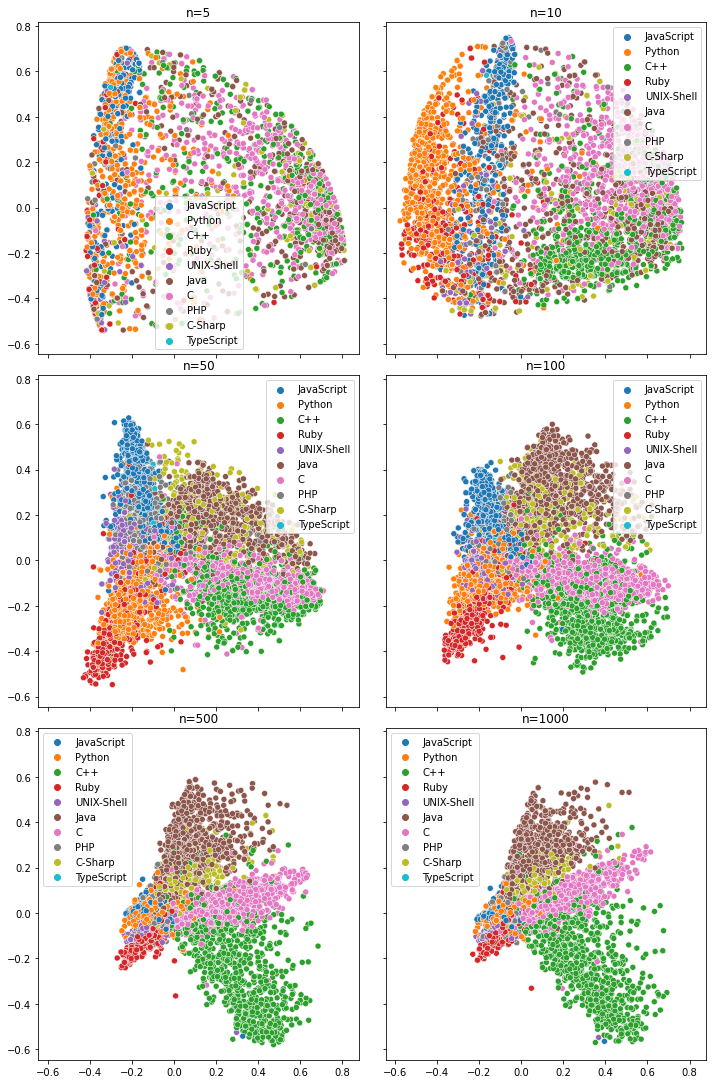

In [198]:
f, axes = plt.subplots(3, 2, figsize=(10, 15), sharey='all', sharex='all')
f.tight_layout()

i = 0
for n in [5, 10, 50, 100, 500, 1000]:
    ax = axes[i//2][i%2]
    ax.title.set_text(f"n={n}")
    pca_tfidf = vectorize_and_pca(dataset, n)
    sns.scatterplot(x=[item[0] for item in pca_tfidf], \
                    y=[item[1] for item in pca_tfidf], \
                    hue=[item[LABEL_IDX] for item in dataset], \
                    ax=ax)
    # plt.subplots_adjust(hspace = 0.4, wspace=0.2)
    i += 1

plt.show()

We can see that increasing the vocabulary size up to 50 causes a very significant difference in the output.
n=100 seems to be the optimal choice, while increasing the vocabulary size above n=100 seems to have a detrimental effect.

### Summary

From our analysis, we can theorize that using the following features can be used to classify a programming language sample in an accurate manner - 
1. The top 5 most common special characters in the sample
2. The top 100 most important tokens in the sample, using TF-IDF

Therefore, going forward, we will use a vector containing these two feature types to represent each sample.

### Classification - First Attempt

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix

SPECIAL_CHARACTERS = string.punctuation

#### Preparing the dataset

We will prepare a pipeline that processes the raw samples retrieved from Rosetta Code into feature vectors for classifiction.

In [253]:
samples, labels = zip(*dataset)
samples_train, samples_test, labels_train, labels_test = train_test_split(samples, labels, random_state=SEED, stratify=labels)

In [26]:
def preprocess_train(samples):
    # Top 5 special characters
    count_vectorizer = CountVectorizer(vocabulary=SPECIAL_CHARACTERS, analyzer='char')
    special_char_vector = count_vectorizer.fit_transform(samples)
    top_5_special = np.fliplr(special_char_vector.A.argsort())[:,:5]

    # Top 100 most important tokens using TF-IDF
    tf_idf_vectorizer = TfidfVectorizer(token_pattern=CUSTOM_TOKEN_RE, lowercase=False, max_features=100)
    top_100_tokens = tf_idf_vectorizer.fit_transform(samples).A

    train_X = np.concatenate((top_5_special, top_100_tokens), axis=1)
    return train_X, count_vectorizer, tf_idf_vectorizer

def preprocess_test(samples, count_vectorizer, tf_idf_vectorizer):
    # Top 5 special characters
    special_char_vector = count_vectorizer.transform(samples)
    top_5_special = np.fliplr(special_char_vector.A.argsort())[:,:5]

    # Top 100 most important tokens using TF-IDF
    top_100_tokens = tf_idf_vectorizer.transform(samples).A

    test_X = np.concatenate((top_5_special, top_100_tokens), axis=1)
    return test_X

In [ ]:
train_X, cv, tfidfv = preprocess_train(samples_train)
test_X = preprocess_test(samples_test, cv, tfidfv)

#### Model baseline - Naive Bayes
For our first attempt, we will try using a naive Bayesian classifier, using sklearn's `MultinomialNB`, and examine the results.

In [255]:
classifier = MultinomialNB()
classifier.fit(train_X, labels_train)

MultinomialNB()

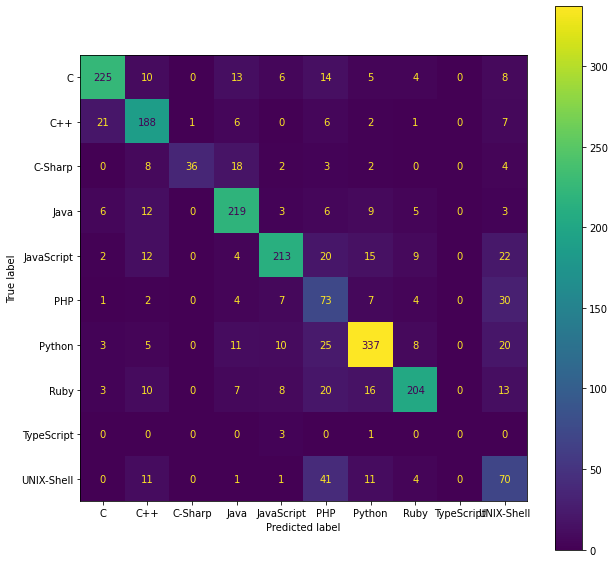

In [264]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(classifier, test_X, labels_test, ax=ax)

In [263]:
accuracy_score(labels_test, classifier.predict(test_X))

0.7378595002357379

We have an accuracy of 73.8%, which is good for a baseline.

For initial conclusions, we can see the classifier failed consistently for TypeScript, but also that very few samples were considered, it seems our dataset has a lack of these samples that we should improve.

But before we jump to conclusions, let's try a couple more classifiers to make sure this isn't just a fault of the model chosen.

I chose to use `RandomForestClassifier` and `SVC`, both simple and popular models for classifiers.

Firstly, for the random forest classifier - 

0.8788307402168788


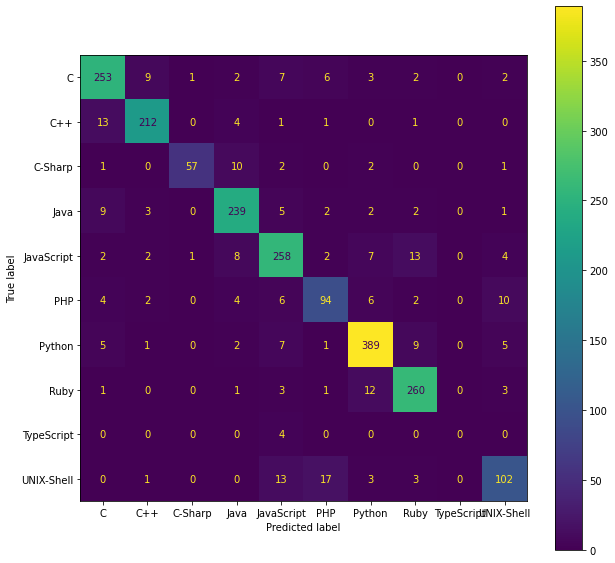

In [271]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_X, labels_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(forest_classifier, test_X, labels_test, ax=ax)
print(accuracy_score(labels_test, forest_classifier.predict(test_X)))

And second, the SVC classifier - 

0.3347477604903347


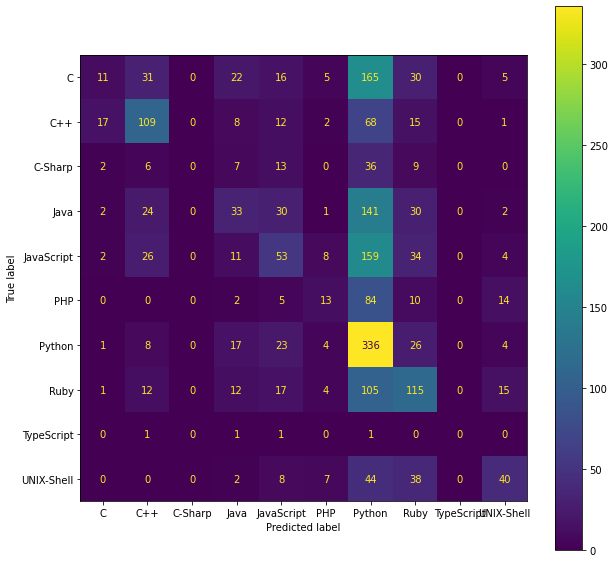

In [273]:
svm_classifier = SVC()
svm_classifier.fit(train_X, labels_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_classifier, test_X, labels_test, ax=ax)
print(accuracy_score(labels_test, svm_classifier.predict(test_X)))

Interestingly, while SVM performs quite badly for this data, we can see the naive usage of Random Forest already gave us an accuracy score of 87.9%! An increase of almost 15% in accuracy with virtually no effort. Nice!

In addition, we cann see the random forest model performs consistently better than the NaiveBayes and SVM models across all categories, and that TypeScript classification is still consistently bad.

Seeing as this will be a significant block in our ability to classify, we will try to acquire more typescript samples.

### Getting more data
As we found out in our initial attempt for classification, we might not have enough samples for effective training of classifiers, and that deficit is especially apparent when trying to classify TypeScript samples.

To get more samples, I opted to use one of the biggest (if not the biggest) sources of open-source source code - GitHub.

GitHub is a platform where anyone can store source code, display, share it, and manage its ongoing development.

As the code hosted on GitHub is publicly available, and can be acquired using a comfortable API, I'll try to create a process to automatically extract source code samples.

To avoid implementing these API's manually, I used PyGitHub.

In [334]:
from github import Github
from getpass import getpass
import requests
import zipfile
import io
import glob
import shutil
import csv
import sys

DATASET_PATH = "github_dataset.csv"

In [3]:
def get_repos_by_language(language, token=None):
    # A GitHub PAT is used to allow a higher rate limit
    gh = Github(token)
    return gh.search_repositories(f"language:{LANGUAGE_TO_SEARCH_TERM[language]}")

def download_repo(repo, path):
    url = repo.get_archive_link("zipball")
    response = requests.get(url)
    content = response.content
    with zipfile.ZipFile(io.BytesIO(content), "r") as zf:
        zf.extractall(path)
    
LANGUAGE_TO_SEARCH_TERM = {
    "JavaScript": "javascript",
    "Python": "python",
    "Java": "java",
    "TypeScript": "typescript",
    "C-Sharp": "csharp",
    "PHP": "php",
    "C++": "cpp",
    "C": "c",
    "UNIX-Shell": "shell",
    "Ruby": "ruby" 
}

LANGUAGE_TO_EXTENSION = {
    "JavaScript": "js",
    "Python": "py",
    "Java": "java",
    "TypeScript": "ts",
    "C-Sharp": "cs",
    "PHP": "php",
    "C++": "cpp",
    "C": "c",
    "UNIX-Shell": "sh",
    "Ruby": "rb"
}

def get_language_files(path, language):
    filename_list = []

    if not path.endswith("/"):
        root_dir = f"{path}/"
    else:
        root_dir = path

    pattern = f"**/*.{LANGUAGE_TO_EXTENSION[language]}"
    for filename in glob.iglob(root_dir + pattern, recursive=True):
        filename_list.append(filename)
    return filename_list

In [320]:
def get_language_dataset(language, repo_count_per_language=10, token=None):
    samples = []
    repos_paginated = get_repos_by_language(language, token)
    chosen_repos = repos_paginated[0:repo_count_per_language]
    for repo in chosen_repos:
        try:
            download_repo(repo, repo.name)
            for file_path in get_language_files(repo.name, language):
                with open(file_path, "rb") as input_file:
                    samples.append(input_file.read())
            shutil.rmtree(repo.name)
        except:
              pass
            
    return samples, [language] * len(samples)

In [319]:
def build_dataset(languages, repo_count_per_language=10):
    samples = []
    labels = []

    token = getpass("Enter a GitHub PAT: ")
    for language in languages:
        print(f"Collecting samples for language: {language}")
        lang_samples, lang_labels = get_language_dataset(language, repo_count_per_language, token)
        samples += lang_samples
        labels += lang_labels
  
    return samples, labels

In [321]:
big_dataset = build_dataset(TOP_LANGUAGES)

Enter a GitHub PAT: ········


In [351]:
len(big_dataset[0])

158018

#### Saving the new dataset

The dataset is now saved to avoid refetching it from GitHub every time (which is tedious and slow).

In [337]:
def save_dataset(dataset, path):
    big_dataset_tuples = zip(dataset[0], dataset[1])
    with open(path, "w", newline='') as out_file:
        csv_writer = csv.writer(out_file)
        for row in big_dataset_tuples:
            try:
                decoded = row[0].decode("utf-8")
                cleaned = decoded.replace('\x00', '')
                csv_writer.writerow([cleaned, row[1]])
            except:
                pass

In [347]:
save_dataset(big_dataset, DATASET_PATH)

NameError: name 'big_dataset' is not defined

#### Reloading the new dataset

And now the dataset is reloaded from disk (future executions of the notebook can skip to this step).

In [332]:
def load_dataset(path):
    new_dataset = []
    csv.field_size_limit(sys.maxsize)
    with open(path, newline='') as in_file:
        csv_reader = csv.reader(in_file)
        for row in csv_reader:
            new_dataset.append(row)
    return new_dataset

In [336]:
new_dataset = load_dataset(path)

#### Retry with the new dataset

Let's try revisiting the `RandomForestClassifier` model, this time with our new and expanded dataset.

In [339]:
samples, labels = zip(*new_dataset)
samples_train, samples_test, labels_train, labels_test = train_test_split(samples, labels, random_state=SEED, stratify=labels)

In [340]:
train_X, cv, tfidfv = preprocess_train(samples_train)
test_X = preprocess_test(samples_test, cv, tfidfv)

0.9848120491077079


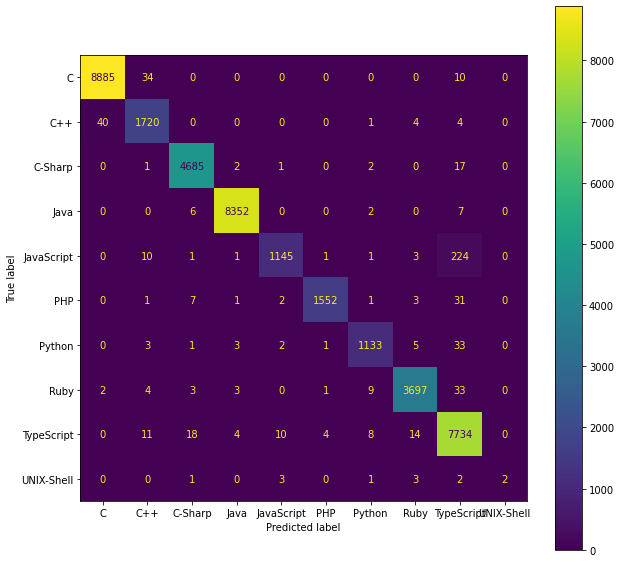

In [341]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_X, labels_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(forest_classifier, test_X, labels_test, ax=ax)
print(accuracy_score(labels_test, forest_classifier.predict(test_X)))

An accuracy of 98.5%! Interseting!

We can see the increase in the dataset size dramatically increases the classifier's accuracy.

Interestingly, we can see the dataset had very few UNIX-Shell samples, and accordingly the accuracy score there is very low

Before we try to fix this, let's see how well does our newly retrained model generalize to our old dataset.

In [343]:
old_samples, old_labels = zip(*dataset)
old_test_X = preprocess_test(old_samples, cv, tfidfv)

0.3193019691074166


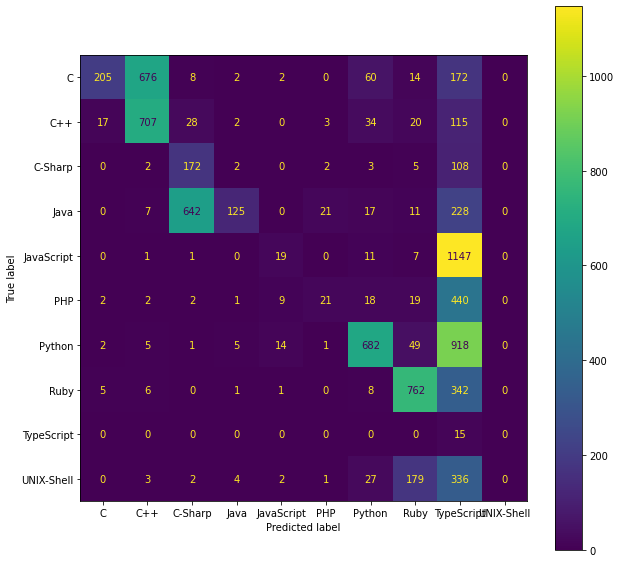

In [345]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(forest_classifier, old_test_X, old_labels, ax=ax)
print(accuracy_score(old_labels, forest_classifier.predict(old_test_X)))

An accuracy of 32%, and a confusion matrix that hints that the classifier is very strongly leaning towards a single label.

Unfortunately, we can see the classifier is overfitting strongly to the dataset from GitHub, and as a result can is very bad at classifying samples from the old dataset.

We can think of 2 main reasons why this can happen -
1. The dataset diversity is low - This makes sense, as only 10 repositories were considered for each programming language. Different files, considered as different samples in our model, might be very similar as they are written by the same person / team.
2. The model is too simple and can't generalize enough to correctly classify samples from the two datasets.

#### Fixing the dataset 

We'll try to get two birds in one shot by redesigning our dataset collection logic -
1. Instead of grabbing all the files in a GitHub repository, only random 5 files per repository will be considered as samples.
2. We will keep collecting more repositories until a minimum of 1500 samples per language is reached. This should takes us about 300 repositories per language (Given that most repositories should contain more than 5 source code files).

The new implementation follows.

In [10]:
def get_repo_samples(language, repo, max_samples_per_repo=5):
    samples = []
    download_repo(repo, repo.name)
    language_files = get_language_files(repo.name, language)
    random.shuffle(language_files)
    for file_path in language_files:
        with open(file_path, "rb") as input_file:
            samples.append(input_file.read())
        if len(samples) > max_samples_per_repo:
            return samples
    
def get_language_dataset(language, min_sample_count=1500, max_samples_per_repo=5, token=None):
    samples = []
    repos_paginated = get_repos_by_language(language, token)
    for repo in repos_paginated:
        try:
            try:
                samples += get_repo_samples(language, repo, max_samples_per_repo)
            finally:
                shutil.rmtree(repo.name)
        except:
            print(f"\t[-] Error fetching repository - {repo.name}")
        
        if len(samples) > min_sample_count:
            return samples, [language] * len(samples)
  
    raise IndexError("Could not fetch enough samples!")

In [11]:
def build_dataset(languages, min_sample_count=1500, max_samples_per_repo=5, with_token=True):
    samples = []
    labels = []
    
    if with_token:
        token = getpass("Enter a GitHub PAT: ")
    else:
        token = None
        
    for language in languages:
        print(f"[*] Collecting samples for language - {language}")
        lang_samples, lang_labels = get_language_dataset(language, \
                                                     min_sample_count, \
                                                     max_samples_per_repo, 
                                                     token)
        samples += lang_samples
        labels += lang_labels
  
    return samples, labels

In [12]:
improved_dataset1 = build_dataset(TOP_LANGUAGES)

Enter a GitHub PAT: ········
[*] Collecting samples for language - JavaScript
	[-] Error fetching repository - 30-seconds-of-code
	[-] Error fetching repository - nodebestpractices
	[-] Error fetching repository - awesome-selfhosted
	[-] Error fetching repository - clean-code-javascript
	[-] Error fetching repository - resume.github.com
	[-] Error fetching repository - DeepLearning-500-questions
	[-] Error fetching repository - awesome-mac
	[-] Error fetching repository - chinese-poetry
	[-] Error fetching repository - awesome-react-native
	[-] Error fetching repository - slick
	[-] Error fetching repository - chinese-poetry
	[-] Error fetching repository - awesome-react-native
	[-] Error fetching repository - awesome-vscode
	[-] Error fetching repository - zx
	[-] Error fetching repository - fe-interview
	[-] Error fetching repository - js-stack-from-scratch
	[-] Error fetching repository - reselect
	[-] Error fetching repository - FileSaver.js
	[-] Error fetching repository - awesome

	[-] Error fetching repository - fmt
	[-] Error fetching repository - tink
	[-] Error fetching repository - wkhtmltopdf
	[-] Error fetching repository - onnx
	[-] Error fetching repository - tinyrenderer
	[-] Error fetching repository - 3d-game-shaders-for-beginners
	[-] Error fetching repository - mosh
	[-] Error fetching repository - muduo
	[-] Error fetching repository - Tars
	[-] Error fetching repository - abseil-cpp
	[-] Error fetching repository - annoy
	[-] Error fetching repository - iOSInterviewQuestions
	[-] Error fetching repository - capnproto
	[-] Error fetching repository - pyxel
	[-] Error fetching repository - node-canvas
	[-] Error fetching repository - kakoune
	[-] Error fetching repository - or-tools
	[-] Error fetching repository - ninja
	[-] Error fetching repository - sanitizers
	[-] Error fetching repository - scylla
	[-] Error fetching repository - rr
	[-] Error fetching repository - gperftools
	[-] Error fetching repository - seastar
	[-] Error fetching reposi

	[-] Error fetching repository - haoel.github.io
	[-] Error fetching repository - pyenv-virtualenv
	[-] Error fetching repository - LinEnum
	[-] Error fetching repository - docker-ipsec-vpn-server
	[-] Error fetching repository - Actions-OpenWrt
	[-] Error fetching repository - standard-readme
	[-] Error fetching repository - create_ap
	[-] Error fetching repository - openwrt-fanqiang
	[-] Error fetching repository - awesome-bash
	[-] Error fetching repository - pipework
	[-] Error fetching repository - containers-roadmap
	[-] Error fetching repository - mac-dev-playbook
	[-] Error fetching repository - jenv
	[-] Error fetching repository - rfcs
	[-] Error fetching repository - prowler
	[-] Error fetching repository - gosu
	[-] Error fetching repository - awesome-audio-visualization
	[-] Error fetching repository - the-bread-code
	[-] Error fetching repository - wifi-password
	[-] Error fetching repository - riak
	[-] Error fetching repository - airgeddon
	[-] Error fetching repository

	[-] Error fetching repository - aria2.conf
	[-] Error fetching repository - log2ram
	[-] Error fetching repository - frontdesk
	[-] Error fetching repository - tmux-config
	[-] Error fetching repository - idea-live-templates
	[-] Error fetching repository - ffscreencast
	[-] Error fetching repository - nodenv
	[-] Error fetching repository - Continuity-Activation-Tool
	[-] Error fetching repository - WebIDE
	[-] Error fetching repository - rpi-clone
	[-] Error fetching repository - learn-with-open-source
	[-] Error fetching repository - getssl
	[-] Error fetching repository - TLP
	[-] Error fetching repository - anyenv
	[-] Error fetching repository - zsh-nvm
	[-] Error fetching repository - bashstrap
	[-] Error fetching repository - aria2.sh
	[-] Error fetching repository - linux-surface
	[-] Error fetching repository - qemu-rpi-kernel
	[-] Error fetching repository - neohosts
	[-] Error fetching repository - fang-hacks
	[-] Error fetching repository - LARBS
	[-] Error fetching repos

	[-] Error fetching repository - Sudomy
	[-] Error fetching repository - vessel
	[-] Error fetching repository - manrope
	[-] Error fetching repository - qemu-user-static
	[-] Error fetching repository - tmux-sensible
	[-] Error fetching repository - pfetch
	[-] Error fetching repository - ant-build-script
	[-] Error fetching repository - Bjango-Templates
	[-] Error fetching repository - settler
	[-] Error fetching repository - rickrollrc
	[-] Error fetching repository - safetynet-fix
	[-] Error fetching repository - eslint-prettier-airbnb-react
	[-] Error fetching repository - kali-whoami
	[-] Error fetching repository - Shr3dKit
	[-] Error fetching repository - bitpocket
	[-] Error fetching repository - fzf-tab
	[-] Error fetching repository - Enable-HiDPI-OSX
	[-] Error fetching repository - mantra
	[-] Error fetching repository - zsh-autocomplete
	[-] Error fetching repository - purge-wrangler
	[-] Error fetching repository - nvm.fish
	[-] Error fetching repository - notes
	[-] Err

Great. Let's save the dataset and reload it from the disk like last time.

In [338]:
save_dataset(improved_dataset, DATASET_PATH)

In [339]:
new_dataset = load_dataset(DATASET_PATH)

And now, let's run the classifier again and see if anything changed.

In [342]:
samples, labels = zip(*new_dataset)
samples_train, samples_test, labels_train, labels_test = train_test_split(samples, labels, random_state=SEED, stratify=labels)

In [343]:
train_X, cv, tfidfv = preprocess_train(samples_train)
test_X = preprocess_test(samples_test, cv, tfidfv)

0.9107618540223761


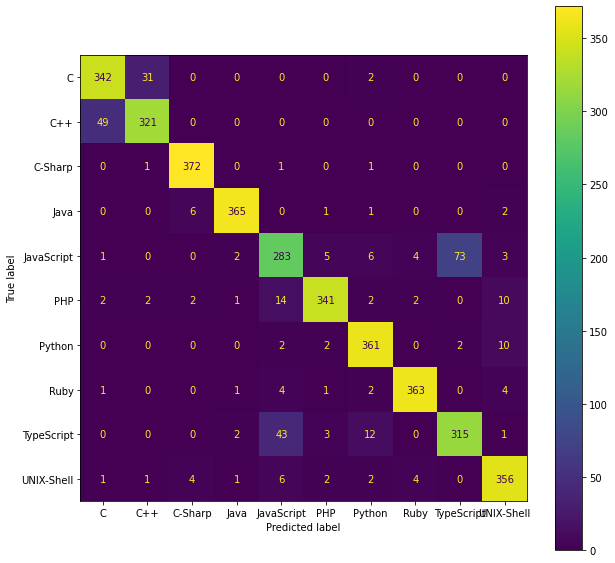

In [344]:
forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_X, labels_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(forest_classifier, test_X, labels_test, ax=ax)
print(accuracy_score(labels_test, forest_classifier.predict(test_X)))

An accuracy of 91%. Not as good as last time, but not bad.

In addition, we finally see we have enough samples of every programming language, which is good for training a balanced classifier.

Let's see how does the model do with the old dataset, something the previously trained model had difficulties with.

In [345]:
old_samples, old_labels = zip(*dataset)
old_test_X = preprocess_test(old_samples, cv, tfidfv)

0.7435443933498408


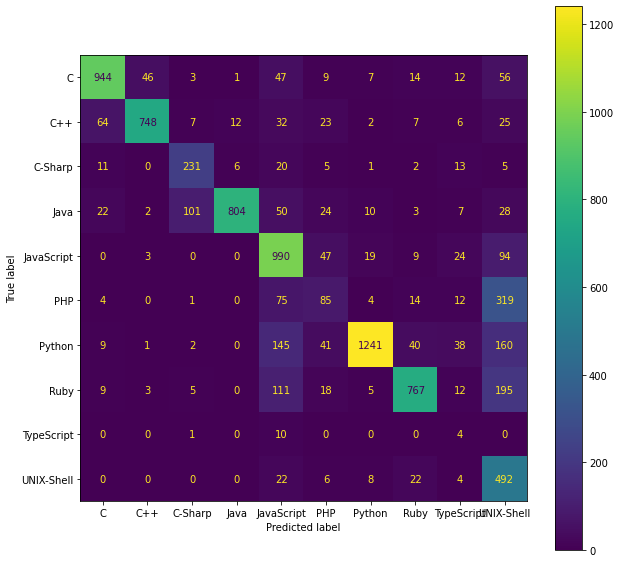

In [346]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(forest_classifier, old_test_X, old_labels, ax=ax)
print(accuracy_score(old_labels, forest_classifier.predict(old_test_X)))

Here the results are much better than last time, although still not very good.

It seems this is partly our model's fault. We'll try finding a more powerful model to try and see how it deals with this problem.

### Classification - second attempt

Another very commonly used model we will try to use is XGBoost.

According to the XGBoost website - 
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
> It implements machine learning algorithms under the Gradient Boosting framework.

Let's try it and see if it makes any difference for our dataset.

In [68]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# SPECIAL_CHARACTERS = 
# CUSTOM_TOKEN_RE = 

In [179]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_special_characters, n_tokens):
        self._countv = CountVectorizer(vocabulary=SPECIAL_CHARACTERS, analyzer='char')
        self._tfidfv = TfidfVectorizer(token_pattern=CUSTOM_TOKEN_RE, lowercase=False, max_features=n_tokens)
        self.n_special_characters = n_special_characters
        self.n_tokens = n_tokens
    
    def fit(self, x, y=None):
        self._countv.fit(x)
        self._tfidfv.fit(x)
        return self
    
    def transform(self, x):
        # Top n special characters
        special_char_vector = self._countv.transform(x)
        top_5_special = np.fliplr(special_char_vector.A.argsort())[:,:self.n_special_characters]

        # Top n most important tokens using TF-IDF
        top_100_tokens = self._tfidfv.transform(x).A
        
        final_x = np.concatenate((top_5_special, top_100_tokens), axis=1)     
        return final_x

In [194]:
def test_classifier(classifier, x, y):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(classifier, x, y, ax=ax)
    print(accuracy_score(y, classifier.predict(x)))

In [190]:
pipeline = Pipeline([("preprocessor", PreprocessingTransformer(5, 100)), \
                     ("classifier", XGBClassifier())])

In [348]:
pipeline.fit(samples_train, labels_train)

/Users/amith/Documents/Personal/University/project/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 PreprocessingTransformer(n_special_characters=5,
                                          n_tokens=100)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1,

0.9195524773574854


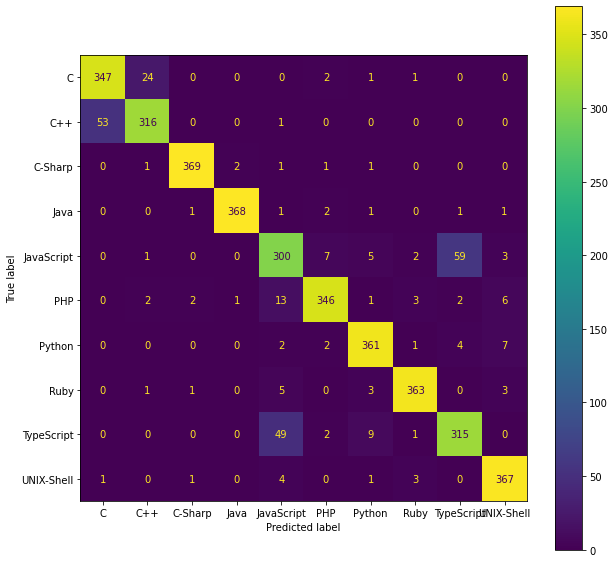

In [349]:
test_classifier(pipeline, samples_test, labels_test)

Similar scores to before, which is good.
Now for the old dataset - 

0.75958023817946


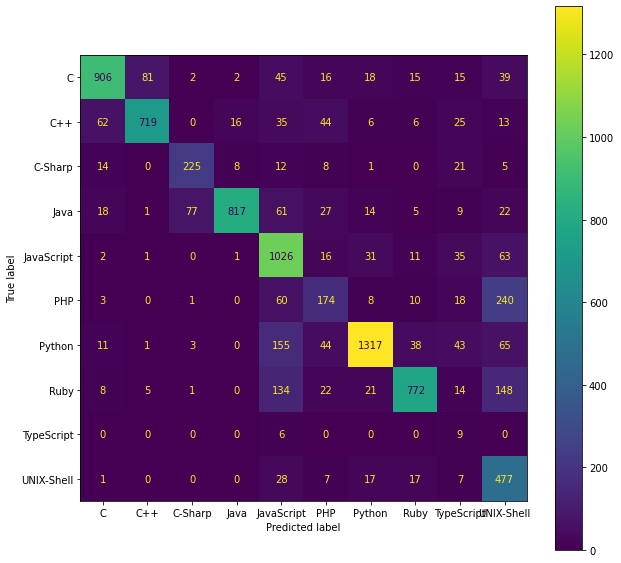

In [350]:
old_samples, old_labels = zip(*dataset)
test_classifier(pipeline, old_samples, old_labels)

We're seeing negligble difference compared to the previous model we tested.

Let's try examining the misclassified samples. In particular, let's look at the Python samples that were misclassified as JavaScript

In [357]:
predictions = pipeline.predict(old_samples)
indexes = [ind for ind, label in enumerate(predictions) \
           if label != old_labels[ind] \
           and label == "JavaScript" \
           and old_labels[ind] == "Python"]

In [365]:
for i in range(10):
    print("*** START ***")
    print(old_samples[indexes[i]])
    print("*** END ***")
    print()

*** START ***
myArray = list()
for x in range(height):
   myArray.append([0] * width)

*** END ***

*** START ***
import math
math.factorial(n)

*** END ***

*** START ***
sendemail(from_addr    = 'python@RC.net',
          to_addr_list = ['RC@gmail.com'],
          cc_addr_list = ['RC@xx.co.uk'],
          subject      = 'Howdy',
          message      = 'Howdy from a python function',
          login        = 'pythonuser',
          password     = 'XXXXX')

*** END ***

*** START ***
# Or without the temp variable
# (it's up to the reader to decide how "pythonic" this is or isn't)
results = {
    0: foo,
    1: bar,
    2: baz,
}.get(x, boz)()

*** END ***

*** START ***
while not stack.empty():

*** END ***

*** START ***
#!/usr/bin/python
# -*- coding: utf-8 -*-

import spread

PORT = '4803'

conn = spread.connect(PORT)
conn.join('test')

conn.multicast(spread.RELIABLE_MESS, 'test', 'hello, this is message sent from python')
conn.disconnect()

*** END ***

*** START ***
values = ra

It appears a large percent of the misclassified samples were very short snippets.

This makes a lot of sense, as shorter samples means less raw text data, and less raw text data gives us less data for classification.

In my opinion, we have two ways we can go from here - 
1. We mix the two datasets togther so we have both shorter and longer snippets of code.
2. We split the larger snippets into chunks and train our system on these chunks.

I've opted to go for option no. 1. The reasons are - 
1. Trying to predict the language for larger snippets using a classifier trained on shorter chunks will probably return results that are not as good as a classifier trained on a classifier trained on longer snippets.
2. We could split larger chunks into smaller chunks, classify each chunk separately and then use the majority vote to get the prediction for the entire large chunk, but this is a bit cubersome and loses some important nuances in the classification.
3. Many of the files in GitHub have licensing and ownership data embedded as comments in the text. Chunks containing only these excerpts will hurt the training process, and these data is difficult to get rid of as it is often decorated in different ways.
4. The Rosetta Code dataset and the GitHub dataset are similar in size (The GitHub dataset is only 2x bigger), so mixing the two datasets will probably result in a well-balanced dataset containing samples of different lengths.

So let's go ahead.

In [374]:
mixed_dataset = dataset + new_dataset
samples, labels = zip(*mixed_dataset)
samples_train, samples_test, labels_train, labels_test = train_test_split(samples, labels, random_state=SEED, stratify=labels)

And let's see the new classification performance for the mixed dataset, using the XGBoost model (which is currently the best).

/Users/amith/Documents/Personal/University/project/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.896


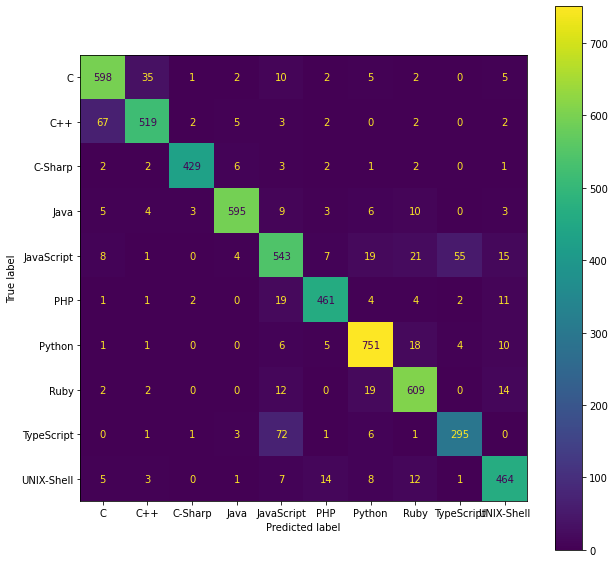

In [368]:
pipeline.fit(samples_train, labels_train)
test_classifier(pipeline, samples_test, labels_test)

Our accuracy for the mixed dataset using XGBoost is almost 90%, which is not bad.

It is interesting to note that most of the samples misclassified were mixups between C / C++ and JavaScript / TypeScript. This connects to my earlier beliefs that these languages are very similar (based on each other) and as such would be difficult to tell apart.

### Classification - ANN

To get the best results possible, we should try using an ANN to solve our problem. Historically, these models get the best results, normally at the price of complexity of the resulting model and difficulty of building it.

I'll try to build a simple 3-layer classifier using Keras and Tensorflow.

In [381]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model

In [378]:
def create_model(n_features, n_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=n_features, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation="softmax"))
    return model

In [395]:
def encode_labels(labels, classes):
    sorted_classes = sorted(classes)
    y = labels
    y_encoded = np.searchsorted(sorted_classes, y)
    y_onehot = to_categorical(y_encoded)
    return y_onehot

In [418]:
model = create_model(105, 10)

In [380]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               13568     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 31,370
Trainable params: 31,370
Non-trainable params: 0
_________________________________________________________________


In [382]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Our model is composed of 3 fully-connected layers, of which the two first fully-connected layers are of 128 dimensionality and use ReLU activation, and the final output layer is of 10 dimensionality (corresponding to the number of target classes) with softmax activation.

Let's try training this model, and checking the performance.
Note I've opted to split my dataset further into train, validation and test datasets, so that when we tune the hyperparameters of the model we won't overfit the test dataset.

In [386]:
samples, labels = zip(*mixed_dataset)
samples_train_validation, samples_test, labels_train_validation, labels_test = train_test_split(samples, labels, test_size=0.1, random_state=SEED, stratify=labels)
samples_train, samples_validation, labels_train, labels_validation = train_test_split(samples_train_validation, labels_train_validation, random_state=SEED, stratify=labels_train_validation)

In [462]:
preprocessor = PreprocessingTransformer(5, 100)
train_X = preprocessor.fit_transform(samples_train)
validation_X = preprocessor.transform(samples_validation)
test_X = preprocessor.transform(samples_test)

In [463]:
train_Y = encode_labels(labels_train, TOP_LANGUAGES)
validation_Y = encode_labels(labels_validation, TOP_LANGUAGES)
test_Y = encode_labels(labels_test, TOP_LANGUAGES)

In [437]:
model = create_model(105, 10)
model.compile(Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [438]:
batch_size = 4
epochs = 500

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)


model.fit(train_X, train_Y, batch_size=batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 4s 854us/step - loss: 1.6487 - accuracy: 0.4144 - val_loss: 0.7053 - val_accuracy: 0.7585
Epoch 2/500
3965/3965 [==============================] - 3s 846us/step - loss: 0.6927 - accuracy: 0.7624 - val_loss: 0.5716 - val_accuracy: 0.8067
Epoch 3/500
3965/3965 [==============================] - 3s 839us/step - loss: 0.6084 - accuracy: 0.7929 - val_loss: 0.5516 - val_accuracy: 0.8109
Epoch 4/500
3965/3965 [==============================] - 3s 845us/step - loss: 0.5810 - accuracy: 0.8040 - val_loss: 0.5199 - val_accuracy: 0.8171
Epoch 5/500
3965/3965 [==============================] - 3s 846us/step - loss: 0.5553 - accuracy: 0.8122 - val_loss: 0.5274 - val_accuracy: 0.8237
Epoch 6/500
3965/3965 [==============================] - 3s 838us/step - loss: 0.5458 - accuracy: 0.8156 - val_loss: 0.4873 - val_accuracy: 0.8383
Epoch 7/500
3965/3965 [==============================] - 3s 848us/step - loss: 0.5389 - accuracy: 0.8169 - val_loss: 0

3965/3965 [==============================] - 4s 908us/step - loss: 0.3981 - accuracy: 0.8627 - val_loss: 0.4967 - val_accuracy: 0.8489
Epoch 112/500
3965/3965 [==============================] - 4s 905us/step - loss: 0.4042 - accuracy: 0.8606 - val_loss: 0.4995 - val_accuracy: 0.8489
Epoch 113/500
3965/3965 [==============================] - 3s 852us/step - loss: 0.4066 - accuracy: 0.8629 - val_loss: 0.4891 - val_accuracy: 0.8483
Epoch 114/500
3965/3965 [==============================] - 3s 878us/step - loss: 0.3973 - accuracy: 0.8679 - val_loss: 0.4958 - val_accuracy: 0.8421
Epoch 115/500
3965/3965 [==============================] - 4s 884us/step - loss: 0.4114 - accuracy: 0.8573 - val_loss: 0.4837 - val_accuracy: 0.8481
Epoch 116/500
3965/3965 [==============================] - 3s 846us/step - loss: 0.4055 - accuracy: 0.8603 - val_loss: 0.5216 - val_accuracy: 0.8440
Epoch 117/500
3965/3965 [==============================] - 3s 838us/step - loss: 0.4123 - accuracy: 0.8619 - val_loss: 0

In [439]:
model.compile(Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_Y, steps_per_epoch=len(train_X) // batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 4s 822us/step - loss: 0.3514 - accuracy: 0.8758 - val_loss: 0.5266 - val_accuracy: 0.8498
Epoch 2/500
3965/3965 [==============================] - 3s 748us/step - loss: 0.3405 - accuracy: 0.8828 - val_loss: 0.5277 - val_accuracy: 0.8506
Epoch 3/500
3965/3965 [==============================] - 3s 746us/step - loss: 0.3303 - accuracy: 0.8834 - val_loss: 0.5316 - val_accuracy: 0.8500
Epoch 4/500
3965/3965 [==============================] - 3s 763us/step - loss: 0.3306 - accuracy: 0.8813 - val_loss: 0.5493 - val_accuracy: 0.8513
Epoch 5/500
3965/3965 [==============================] - 3s 795us/step - loss: 0.3278 - accuracy: 0.8831 - val_loss: 0.5422 - val_accuracy: 0.8525
Epoch 6/500
3965/3965 [==============================] - 3s 756us/step - loss: 0.3248 - accuracy: 0.8849 - val_loss: 0.5447 - val_accuracy: 0.8510
Epoch 7/500
3965/3965 [==============================] - 3s 745us/step - loss: 0.3272 - accuracy: 0.8873 - val_loss: 0

We see this model struggles to get above 85% accuracy on the validation dataset.
Let's try playing a bit with the hyperparameters of the model to see if we can get a better result.

In [440]:
def create_model(n_features, n_classes, n_dense_dimensions, dropout):
    model = Sequential()
    model.add(Dense(n_dense_dimensions, input_dim=n_features, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(n_dense_dimensions, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation="softmax"))
    return model

Because the validation accuracy is very close to the training accuracy, it seems the model isn't overfitting, so we can reduce the dropout. In addition, we'll try reducing the fully connected layer's dimensionality.

In [442]:
model = create_model(105, 10, 64, 0.15)
model.compile(Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [444]:
batch_size = 4
epochs = 500

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
b
model.fit(train_X, train_Y, batch_size=batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 3s 879us/step - loss: 0.3218 - accuracy: 0.8822 - val_loss: 0.5535 - val_accuracy: 0.8464
Epoch 2/500
3965/3965 [==============================] - 4s 886us/step - loss: 0.3237 - accuracy: 0.8856 - val_loss: 0.5681 - val_accuracy: 0.8477
Epoch 3/500
3965/3965 [==============================] - 4s 910us/step - loss: 0.3208 - accuracy: 0.8837 - val_loss: 0.5582 - val_accuracy: 0.8474
Epoch 4/500
3965/3965 [==============================] - 4s 909us/step - loss: 0.3248 - accuracy: 0.8833 - val_loss: 0.5506 - val_accuracy: 0.8460
Epoch 5/500
3965/3965 [==============================] - 4s 887us/step - loss: 0.3235 - accuracy: 0.8852 - val_loss: 0.5264 - val_accuracy: 0.8498
Epoch 6/500
3965/3965 [==============================] - 3s 876us/step - loss: 0.3202 - accuracy: 0.8868 - val_loss: 0.5567 - val_accuracy: 0.8540
Epoch 7/500
3965/3965 [==============================] - 4s 961us/step - loss: 0.3272 - accuracy: 0.8839 - val_loss: 0

Not much better. Let's try the opposite way - more dropout and more dimensionality in the dense layers.

In [446]:
model = create_model(105, 10, 256, 0.5)
model.compile(Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [447]:
batch_size = 4
epochs = 500

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

model.fit(train_X, train_Y, batch_size=batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 4s 1ms/step - loss: 1.8584 - accuracy: 0.3432 - val_loss: 0.7795 - val_accuracy: 0.7367
Epoch 2/500
3965/3965 [==============================] - 4s 991us/step - loss: 0.8348 - accuracy: 0.7156 - val_loss: 0.5951 - val_accuracy: 0.7976
Epoch 3/500
3965/3965 [==============================] - 4s 990us/step - loss: 0.7256 - accuracy: 0.7554 - val_loss: 0.5341 - val_accuracy: 0.8137
Epoch 4/500
3965/3965 [==============================] - 4s 996us/step - loss: 0.6860 - accuracy: 0.7685 - val_loss: 0.5465 - val_accuracy: 0.8054
Epoch 5/500
3965/3965 [==============================] - 4s 986us/step - loss: 0.6689 - accuracy: 0.7770 - val_loss: 0.5673 - val_accuracy: 0.8033
Epoch 6/500
3965/3965 [==============================] - 4s 1ms/step - loss: 0.6492 - accuracy: 0.7852 - val_loss: 0.5489 - val_accuracy: 0.8120
Epoch 7/500
3965/3965 [==============================] - 4s 991us/step - loss: 0.6444 - accuracy: 0.7856 - val_loss: 0.530

3965/3965 [==============================] - 4s 1ms/step - loss: 0.5828 - accuracy: 0.8125 - val_loss: 0.5552 - val_accuracy: 0.8269
Epoch 114/500
3965/3965 [==============================] - 4s 1ms/step - loss: 0.5660 - accuracy: 0.8175 - val_loss: 0.5424 - val_accuracy: 0.8396
Epoch 115/500
3965/3965 [==============================] - 4s 979us/step - loss: 0.5533 - accuracy: 0.8188 - val_loss: 0.5709 - val_accuracy: 0.8247
Epoch 116/500
3965/3965 [==============================] - 4s 980us/step - loss: 0.5660 - accuracy: 0.8169 - val_loss: 0.5584 - val_accuracy: 0.8309
Epoch 117/500
3965/3965 [==============================] - 4s 986us/step - loss: 0.5620 - accuracy: 0.8158 - val_loss: 0.6165 - val_accuracy: 0.8186
Epoch 118/500
3965/3965 [==============================] - 4s 985us/step - loss: 0.5813 - accuracy: 0.8160 - val_loss: 0.5991 - val_accuracy: 0.8301
Epoch 119/500
3965/3965 [==============================] - 4s 980us/step - loss: 0.5754 - accuracy: 0.8139 - val_loss: 0.553

Not any better either.
Maybe the fault is with the network architecture. Let's try to make it more shallow - 

In [448]:
def create_model(n_features, n_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=n_features, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(n_classes, activation="softmax"))
    return model

In [455]:
model = create_model(105, 10)
model.compile(Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [456]:
batch_size = 4
epochs = 500

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

model.fit(train_X, train_Y, batch_size=batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 4s 871us/step - loss: 1.3649 - accuracy: 0.5695 - val_loss: 0.6138 - val_accuracy: 0.8139
Epoch 2/500
3965/3965 [==============================] - 3s 856us/step - loss: 0.6153 - accuracy: 0.7988 - val_loss: 0.5420 - val_accuracy: 0.8141
Epoch 3/500
3965/3965 [==============================] - 4s 1ms/step - loss: 0.5435 - accuracy: 0.8177 - val_loss: 0.5051 - val_accuracy: 0.8252
Epoch 4/500
3965/3965 [==============================] - 4s 995us/step - loss: 0.5168 - accuracy: 0.8257 - val_loss: 0.5002 - val_accuracy: 0.8300
Epoch 5/500
3965/3965 [==============================] - 3s 844us/step - loss: 0.4977 - accuracy: 0.8292 - val_loss: 0.4826 - val_accuracy: 0.8379
Epoch 6/500
3965/3965 [==============================] - 3s 798us/step - loss: 0.4858 - accuracy: 0.8368 - val_loss: 0.4818 - val_accuracy: 0.8279
Epoch 7/500
3965/3965 [==============================] - 3s 835us/step - loss: 0.4798 - accuracy: 0.8331 - val_loss: 0.4

3965/3965 [==============================] - 3s 701us/step - loss: 0.2851 - accuracy: 0.8967 - val_loss: 0.5800 - val_accuracy: 0.8523
Epoch 112/500
3965/3965 [==============================] - 3s 704us/step - loss: 0.2967 - accuracy: 0.8921 - val_loss: 0.5784 - val_accuracy: 0.8498
Epoch 113/500
3965/3965 [==============================] - 3s 693us/step - loss: 0.2924 - accuracy: 0.8948 - val_loss: 0.5704 - val_accuracy: 0.8606
Epoch 114/500
3965/3965 [==============================] - 3s 679us/step - loss: 0.2908 - accuracy: 0.8940 - val_loss: 0.5630 - val_accuracy: 0.8489
Epoch 115/500
3965/3965 [==============================] - 3s 671us/step - loss: 0.2869 - accuracy: 0.8952 - val_loss: 0.5957 - val_accuracy: 0.8549
Epoch 116/500
3965/3965 [==============================] - 3s 686us/step - loss: 0.2890 - accuracy: 0.8952 - val_loss: 0.6351 - val_accuracy: 0.8504


It looks like the model has a bit more potential. Let's try to continue training using a lower learning rate.

In [457]:
model.compile(Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_Y, batch_size=batch_size, validation_data=(validation_X, validation_Y), epochs=epochs, callbacks=[es, mc])

Epoch 1/500
3965/3965 [==============================] - 3s 721us/step - loss: 0.2479 - accuracy: 0.9114 - val_loss: 0.5922 - val_accuracy: 0.8598
Epoch 2/500
3965/3965 [==============================] - 3s 675us/step - loss: 0.2302 - accuracy: 0.9175 - val_loss: 0.5903 - val_accuracy: 0.8606
Epoch 3/500
3965/3965 [==============================] - 3s 672us/step - loss: 0.2282 - accuracy: 0.9171 - val_loss: 0.5881 - val_accuracy: 0.8602
Epoch 4/500
3965/3965 [==============================] - 3s 676us/step - loss: 0.2243 - accuracy: 0.9186 - val_loss: 0.5912 - val_accuracy: 0.8625
Epoch 5/500
3965/3965 [==============================] - 3s 690us/step - loss: 0.2265 - accuracy: 0.9185 - val_loss: 0.5893 - val_accuracy: 0.8623
Epoch 6/500
3965/3965 [==============================] - 3s 679us/step - loss: 0.2266 - accuracy: 0.9171 - val_loss: 0.5916 - val_accuracy: 0.8606
Epoch 7/500
3965/3965 [==============================] - 3s 711us/step - loss: 0.2258 - accuracy: 0.9189 - val_loss: 0

It looks like we can get a marginally better result, around 86%, from this model.

Let's test it on the (previously untouched) test dataset.

In [466]:
model.evaluate(test_X, test_Y)

74/74 [==============================] - 0s 644us/step - loss: 0.7568 - accuracy: 0.8570


[0.7567644119262695, 0.8570212721824646]

The model is consistent across the test dataset, which means it was trained well, but it doesn't perform exquisitely well.

### Classification - Final attempt

It seems the best model we've tried so far is XGBoost, so let's try to maximize its performance using hyper-parameter tuning.

We will use the hyperopt package to automate this process.

In [467]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [488]:
def encode_labels(labels, classes):
    sorted_classes = sorted(classes)
    y = labels
    y_encoded = np.searchsorted(sorted_classes, y)
    return y_encoded

In [496]:
def objective(space):
    clf = XGBClassifier(n_estimators =1000,
                        colsample_bytree=space['colsample_bytree'],
                        learning_rate = 0.3,
                        max_depth = int(space['max_depth']),
                        min_child_weight = space['min_child_weight'],
                        subsample = space['subsample'],
                        gamma = space['gamma'],
                        reg_lambda = space['reg_lambda'],
                        eval_metric='mlogloss',
                        use_label_encoder=False)
    
    eval_set  = [(train_X, train_Y), (validation_X, validation_Y)]
    
    # Fit the classifier
    clf.fit(train_X, train_Y,
            eval_set=eval_set,
            early_stopping_rounds=10,
            verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(validation_X)
    
    # Calculate our Metric - accuracy
    accuracy = accuracy_score(validation_Y, pred)

    # return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [494]:
space = {'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
         'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
         'subsample': hp.uniform ('x_subsample', 0.7, 1),
         'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
         'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
         'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)}

In [497]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print(best)

100%|██████████████████████| 100/100 [42:06<00:00, 25.27s/trial, best loss: -0.9112918479288822]
{'x_colsample_bytree': 0.8327916785998708, 'x_gamma': 0.255766661847059, 'x_max_depth': 9.0, 'x_min_child': 7.0, 'x_reg_lambda': 0.1581347311012975, 'x_subsample': 0.8402604547039015}


Finally, let's test the tuned model on test data.

In [506]:
xgb = XGBClassifier(n_estimators=1000,
                   colsample_bytree=0.8327916785998708,
                   gamma=0.255766661847059,
                   max_depth=9,
                   min_child_weight=7,
                   reg_lambda=0.1581347311012975,
                   subsample=0.8402604547039015,
                   eval_metric="mlogloss")

In [507]:
xgb.fit(train_X, train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8327916785998708,
              eval_metric='mlogloss', gamma=0.255766661847059, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.1581347311012975, scale_pos_weight=None,
              subsample=0.8402604547039015, tree_method='exact',
              validate_parameters=1, verbosity=None)

0.8936170212765957


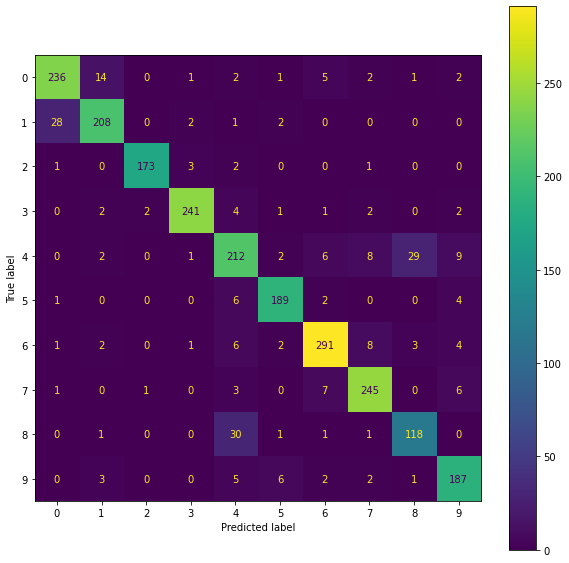

In [508]:
test_classifier(xgb, test_X, test_Y)

After the hyper-parameter tuning, the accuracy of the prediction stayed more or less the same - around 89%

#### Calculating F1 scores

In [510]:
from sklearn.metrics import f1_score

In [516]:
## XGBoost
print(f1_score(test_Y, xgb.predict(test_X), average="weighted"))

0.893759154489485


In [520]:
## RandomForest
forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_X, train_Y)
print(f1_score(test_Y, forest_classifier.predict(test_X), average="weighted"))

0.8846004730500857


In [521]:
## Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(train_X, train_Y)
print(f1_score(test_Y, nb_classifier.predict(test_X), average="weighted"))

0.7048444096581192


In [530]:
## ANN
preds = model.predict(test_X)
# Convert from one-hot back to encoded
preds_encoded = np.argmax(preds, axis=1)
print(f1_score(test_Y, preds_encoded, average="weighted"))

0.8572240080153563


## Improvement ideas

* **Use kerastuner for hyperparameter tuning in Keras** - This idea was left out because generally XGBoost outperformed the ANN model, but it could give the ANN the edge, potentially.
* **Try to classify more programming languages** - I only tried to classify the top 10 programming languages, but generally much more programming languages are commonly in use.
* **Better cleanup process for data** - The data collected from GitHub was generally dirty, with many irrelevant lines, comments and variables with foreign names and etc. The model accuracy would probably benefit from a better cleanup process.
* **Use different features** - It's entirely possible that the features I've chosen weren't good enough. Given more time, I would try to explore more features and test how well they help classify the different programming languages.

## Summary

#### Results
|            | XGBoost | Random Forest | ANN   | Naive Bayes |
|------------|---------|---------------|-------|-------------|
| F1-Score   | 0.894   | 0.885         | 0.858 | 0.705       |

In the end, most of the models I've tried gave good classification scores, but not fantastic, with XGBoost giving the best score at 0.894.

It's interesting to note that the ANN, which I believed would certainly take the lead in the accuracy race, wound up as the runner-up from the end. The architecture I've chosen can, of course, be blamed for this, but I still feel this should have been a better performing model.

After checking the state of the art in the market, it seems my model can still do a better job than say GitHub's Linguist, or Pygments, which rely on manual syntax rule checking and file extensions, but only marginally.

GitHub has written a blog post about their own implementation for deep learning based source classification, named OctoLingua, and they claim to have very good results (99% accuracy with file extensions, 95% without), but currently this project is not open sourced.

#### Self Reflection
* The subject of programming languages is close to my heart. I work as a developer in a cybersecurity company, and our product displays to users and processes a lot of code on a regular basis. Ideas from this project may well find their way into their product, and this is one of the reasons I was very interested to work on it.
* I'll admit that I originally thought this would be an easy subject to master. I thought that source code is very well-structured and should be easy to classify, so I would spend the majority of my time collecting it. Turns out that even considering many different methods, I could only reach a good (although not excellent) score.
* I've learned a lot along the way, particularly about feature engineering and model comparison. I hope these skills will serve me in future works.
* I really appreciated this being such an open project, where we can choose any subject we like and focus on it, as it allowed me to choose a subject that really piqued my interest. I've had some difficulties finding a subject I like, and perhaps would've enjoyed a greater selection of past projects to look at for inspiration, but nonethless I like the freedom that was allowed in this project.